In [ ]:
def running_in_colab():
    """
    Check if the Jupyter Notebook is running in Google Colab.

    Returns:
        bool: True if running in Google Colab, False otherwise.
    """
    try:
        import google.colab

        return True
    except ImportError:
        return False

In [ ]:
#mount data on drive

if running_in_colab():
    from google.colab import drive

    drive.mount("drive")

Mounted at drive


In [ ]:
!pip install datasets
!pip install transformers
!pip install nltk
!pip install gensim
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.1 MB/s eta 0:00:00


In [ ]:
# Pretty print
from pprint import pprint
# Datasets load_dataset function
from datasets import load_dataset, load_from_disk
# Transformers Autokenizer
from transformers import AutoTokenizer
model_name = 'distilroberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
# Standard PyTorch DataLoader
from torch.utils.data import DataLoader
import os

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
# Enter path here
train_path = '/content/drive/MyDrive/patent_data/VDB/train'
val_path = '/content/drive/MyDrive/patent_data/VDB/val'

In [ ]:
# Label-to-index mapping for the decision status field
# decision_to_str = {'REJECTED': 0, 'ACCEPTED': 1, 'PENDING': 2, 'CONT-REJECTED': 3, 'CONT-ACCEPTED': 4, 'CONT-PENDING': 5}


# Helper function
def map_decision_to_string(example):
    return {'decision': decision_to_str[example['decision']]}


if os.path.exists(train_path) and os.path.exists(val_path):
  print('Train and validation sets are cached to: ')
  pprint(train_path)
  pprint(val_path)
  train_set = load_from_disk(train_path)
  val_set = load_from_disk(val_path)
else:
  # loading data, this is just a small set
  dataset_dict = load_dataset('HUPD/hupd',
                              name='all',
                              data_files="https://huggingface.co/datasets/HUPD/hupd/blob/main/hupd_metadata_2022-02-22.feather",
                              icpr_label=None,
                              train_filing_start_date='2015-01-01',
                              train_filing_end_date='2016-12-31',
                              val_filing_start_date='2017-01-01',
                              val_filing_end_date='2017-12-31')

  # Re-labeling/mapping.
  train_set = dataset_dict['train'].map(map_decision_to_string)
  val_set = dataset_dict['validation'].map(map_decision_to_string)
  train_set = train_set.filter(lambda data: data["decision"] <= 1)
  val_set = val_set.filter(lambda data: data["decision"] <= 1)
  train_set = train_set.filter(lambda data: 'A61K' in data["ipc_label"])
  val_set = val_set.filter(lambda data: 'A61K' in data["ipc_label"])
  train_set.save_to_disk(train_path)
  val_set.save_to_disk(val_path)

Train and validation sets are cached to: 
'/content/drive/MyDrive/patent_data/VDB/train'
'/content/drive/MyDrive/patent_data/VDB/val'


## Preprocess data

In [ ]:

import pandas as pd
import numpy as np
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, GlobalMaxPooling1D, Input, concatenate, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model, optimizers
from tensorflow.keras.losses import BinaryCrossentropy

from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')
import string
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
stop_words = set(stopwords.words('english'))
def preprocess(text):
    text = text.lower()
    # text = ''.join([word for word in text if word not in string.punctuation])
    tokens = word_tokenize(text)
    # tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)


In [ ]:
train_set = train_set.to_pandas()
val_set = val_set.to_pandas()

In [ ]:
X_train = train_set['abstract'].apply(preprocess)
X_val = val_set['abstract'].apply(preprocess)

In [ ]:
# # Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
x_train = tokenizer.texts_to_sequences(X_train)
x_val = tokenizer.texts_to_sequences(X_val)
vocab_size = len(tokenizer.word_index) + 1
max_length = 200
x_train = pad_sequences(x_train, maxlen=max_length, padding='post')
x_val = pad_sequences(x_val, maxlen=max_length, padding='post')

In [ ]:
# Train the Word2Vec model
sentences = [sentence.split() for sentence in X_train]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)

In [ ]:
# Create a weight matrix for the embedding layer
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

In [ ]:
# Define the CNN model

def word2vec_cnn_model(vocab_size = vocab_size,
                       max_length = max_length,
                       embedding_matrix = embedding_matrix,
                          num_filters = [131, 127, 51, 23, 17],
                          kernel_sizes = [2, 3, 4, 5, 7],
                          dropout = 0.3,
                          hidden_size = 50,
                          learning_rate=0.00005):


  inputs = Input(shape=(max_length,))
  # # Embedding layer
  # embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=False)(inputs)

  # conv_layers_for_all_kernel_sizes = []
  # for kernel_size, filters in zip(kernel_sizes, num_filters):
  #     conv_layer = Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(embedding_layer)
  #     conv_layer = GlobalMaxPooling1D()(conv_layer)
  #     conv_layers_for_all_kernel_sizes.append(conv_layer)

  # # average_output = tf.math.reduce_mean(last_hidden_state, axis=0)
  # conv_output = concatenate(conv_layers_for_all_kernel_sizes, axis=1)
  # last_hidden_output = Dropout(rate=dropout)(conv_output)

  # hidden = Dense(hidden_size, activation='relu', name='hidden_layer')(last_hidden_output)
  # dropout_layer = Dropout(dropout)(hidden)
  # classification = Dense(1, activation='sigmoid',name='classification_layer')(dropout_layer)
  # classification_model = Model(inputs=inputs, outputs=[classification])
  # classification_model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
  #                               loss=BinaryCrossentropy(from_logits=False),
  #                               metrics='accuracy')

  embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=False)(inputs)

  # Convolutional layers
  conv1 = Conv1D(128, 5, activation='relu')(embedding_layer)
  pool1 = MaxPooling1D(5)(conv1)

  conv2 = Conv1D(128, 5, activation='relu')(pool1)
  pool2 = MaxPooling1D(5)(conv2)

  # Flatten layer
  flatten = Flatten()(pool2)

  # Dense layers
  dense1 = Dense(128, activation='relu')(flatten)
  output = Dense(1, activation='sigmoid')(dense1)

  # Create the model
  model = Model(inputs=inputs, outputs=output)

  # Compile the model
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    ### END YOUR CODE

  return model
  # return classification_model


In [ ]:
word2vec_cnn_model = word2vec_cnn_model()
word2vec_cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 100)          2816600   
                                                                 
 conv1d (Conv1D)             (None, 196, 128)          64128     
                                                                 
 max_pooling1d (MaxPooling1  (None, 39, 128)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 35, 128)           82048     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 7, 128)            0         
 g1D)                                                        

In [ ]:
# from tensorflow.keras.callbacks import ModelCheckpoint

# model_checkpoint_callback = ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_best_only=True,
#     monitor='val_loss',
#     mode='min',
#     verbose=1
# )
word2vec_cnn_model.fit(
    x_train,
    train_set['decision'],
    validation_data=(x_val, val_set['decision']),
    batch_size=8,
    epochs=4,
    # callbacks=[model_checkpoint_callback]
)

Epoch 1/4
1777/1777 [==============================] - 37s 20ms/step - loss: 0.6839 - accuracy: 0.5822 - val_loss: 0.6574 - val_accuracy: 0.6832
Epoch 2/4
1777/1777 [==============================] - 42s 24ms/step - loss: 0.6706 - accuracy: 0.5919 - val_loss: 0.6065 - val_accuracy: 0.6921
Epoch 3/4
1777/1777 [==============================] - 36s 20ms/step - loss: 0.6546 - accuracy: 0.6091 - val_loss: 0.6214 - val_accuracy: 0.6973
Epoch 4/4
1777/1777 [==============================] - 49s 28ms/step - loss: 0.6274 - accuracy: 0.6394 - val_loss: 0.6761 - val_accuracy: 0.6395


## On abstract

In [ ]:
predicted = word2vec_cnn_model.predict(x_val)


43/43 [==============================] - 2s 33ms/step


In [ ]:
predicted = (predicted > 0.5).astype(int)

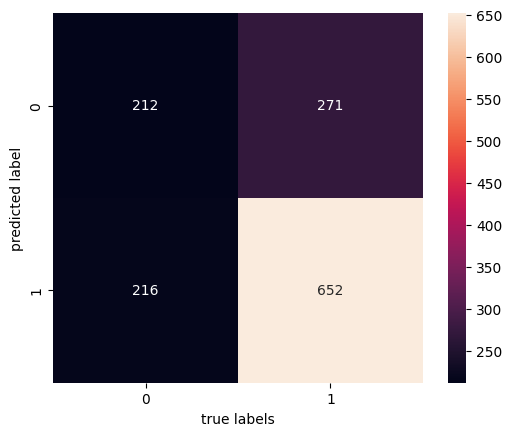

Accuracy: 0.6395262768319763


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

mat = confusion_matrix(val_set['decision'], predicted)
sns.heatmap(mat.T, square = True, annot=True, fmt = "d")
plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.show()
print("Accuracy: {}".format(accuracy_score(val_set['decision'], predicted)))

In [ ]:
print(classification_report(val_set['decision'], predicted))

              precision    recall  f1-score   support

           0       0.44      0.50      0.47       428
           1       0.75      0.71      0.73       923

    accuracy                           0.64      1351
   macro avg       0.60      0.60      0.60      1351
weighted avg       0.65      0.64      0.64      1351

